In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
class BitcoinTradingEnv(gym.Env):
    def __init__(self, df, initial_balance):
        super(BitcoinTradingEnv, self).__init__()
        self.df = df
        self.initial_balance = initial_balance
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(672, 7), dtype=np.float32)
        self.lazy_profit = []
        self.agent_profit = []
        self.initial_price = self.df.iloc[671]['close']

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = 671
        self.balance = self.initial_balance
        self.btc_held = 0
        self.lazy_profit = [0]
        self.last_portfolio_value = self.initial_balance
        self.initial_price = self.df.iloc[0]['close']
        self.agent_profit = []
        return self._next_observation(), {}

    def _next_observation(self):
        market_data = self.df.iloc[self.current_step-671:self.current_step+1, 1:6].values
        current_price = self.df.iloc[self.current_step]['close']
        
        portfolio = np.array([[
            self.balance / self.initial_balance,
            self.btc_held * current_price / self.initial_balance
        ]] * 672)
        
        obs = np.hstack([market_data, portfolio])
        return obs.astype(np.float32)

    def step(self, action):
        action = action.flatten()[0]
        self._take_action(action)
        
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        truncated = False
        
        obs = self._next_observation()
        reward = self._calculate_reward()
        info = {}
        
        self._calculate_lazy_profit()
        self._calculate_agent_profit()
        
        return obs, reward, done, truncated, info
    
    def get_profits(self):
        return self.lazy_profit, self.agent_profit
    
    def _calculate_lazy_profit(self):
        current_price = float(self.df.iloc[self.current_step]['close'])
        initial_btc_amount = self.initial_balance / float(self.initial_price)
        current_value = initial_btc_amount * current_price
        lazy_profit = float(current_value - self.initial_balance)
        self.lazy_profit.append(lazy_profit)
        
    def _calculate_agent_profit(self):
        current_price = self.df.iloc[self.current_step]['close']
        portfolio_value = self.balance + (self.btc_held * current_price)
        agent_profit = portfolio_value - self.initial_balance
        self.agent_profit.append(agent_profit)
        
    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['close']
        
        if action > 0:  # Buy
            btc_to_buy = (self.balance * action) / current_price
            cost = btc_to_buy * current_price
            self.balance -= cost
            self.btc_held += btc_to_buy
        elif action < 0:  # Sell
            btc_to_sell = self.btc_held * abs(action)
            revenue = btc_to_sell * current_price
            self.balance += revenue
            self.btc_held -= btc_to_sell

    def _calculate_reward(self):
        current_price = self.df.iloc[self.current_step]['close']
        portfolio_value = self.balance + self.btc_held * current_price
        reward = (portfolio_value - self.last_portfolio_value)
        self.last_portfolio_value = portfolio_value
        return reward

In [4]:
def preprocess_data(file_path, episode_length=10000):
    df = pd.read_csv(file_path, parse_dates=[0], index_col=0)
    datasets = []
    for i in range(0, len(df) - episode_length + 1, episode_length):
        datasets.append(df.iloc[i:i+episode_length])
    return datasets

In [5]:
def train_agent(env, total_timesteps, epochs):
    model = PPO("MlpPolicy", env, 
                learning_rate=1e-4, 
                n_steps=2048, 
                batch_size=64, 
                n_epochs=10, 
                gamma=0.99, 
                gae_lambda=0.95, 
                clip_range=0.2)
    
    for _ in tqdm(range(epochs), desc="Training..."):
        model.learn(total_timesteps=total_timesteps)
        
    return model

In [6]:
def evaluate_agent(model, env, episodes):
    print("Evaluating agent...")
    
    returns = []
    lazy_profits = []
    agent_profits = []
    
    for episode in tqdm(range(episodes), desc="Evaluating..."):
        obs = env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs)
            step_result = env.step(action)
            if len(step_result) == 5:
                obs, reward, done, truncated, _ = step_result
                done = done or truncated
            elif len(step_result) == 4:
                obs, reward, done, _ = step_result
            else:
                raise ValueError(f"Unexpected number of values returned by step(): {len(step_result)}")
            total_reward += reward if np.isscalar(reward) else reward[0]
            lazy_profit, agent_profit = env.envs[0].get_profits()
            
            # print(f"Lazy Profit: {lazy_profit}")
            # print(f"Agent Profit: {agent_profit}")

            lazy_profits.append(lazy_profit)
            agent_profits.append(agent_profit)
            
        returns.append(total_reward)
    
    return np.mean(returns), agent_profits, lazy_profits

In [7]:
def plot_difference(agent_profit, lazy_profit):
    plt.figure(figsize=(10, 4))

    plt.plot(agent_profit, label='Profit Agent', linewidth=1)
    plt.plot(lazy_profit, label='Profit Lazy', linewidth=1)

    plt.xlabel('Time Period')
    plt.ylabel('Profit')
    plt.title('Profit Comparison: Agent vs Lazy')
    plt.legend()

    formatter = FuncFormatter(lambda x, _: f'₩{int(x):,}')
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()

In [14]:
def plot_evaluation(data, title='Price', ylabel='Price'):
    plt.figure(figsize=(10, 4))

    plt.plot(data, label='Price', linewidth=1)

    plt.xlabel('Episodes')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

    formatter = FuncFormatter(lambda x, _: f'₩{int(x):,}')
    plt.gca().yaxis.set_major_formatter(formatter)

    plt.show()

In [ ]:
datasets = preprocess_data("../../data/KRW-BTC.csv")

env = DummyVecEnv([lambda: BitcoinTradingEnv(datasets[0], initial_balance=1000000)])

total_timesteps = 10000
epochs = 100
model = train_agent(env, total_timesteps, epochs)

episodes = 3
mean_return, agent_profit, lazy_profit = evaluate_agent(model, env, episodes)
print(f"Mean return over {episodes} episodes: {mean_return:,.2f}")
plot_difference(agent_profit[27000], lazy_profit[27000])

Training...:  20%|██        | 20/100 [01:45<07:00,  5.26s/it]

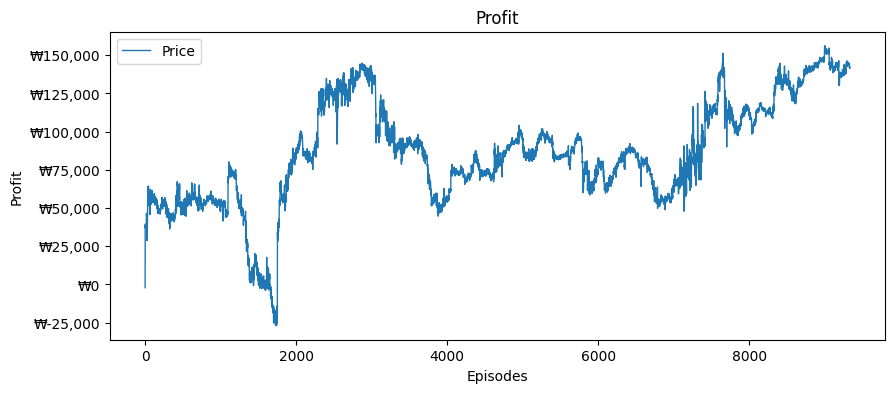

In [13]:
final_difference = [agent_profit[0][i] - lazy_profit[0][i] for i in range(len(agent_profit[0]))]
plot_evaluation(final_difference, title='Profit Difference Between Agent and Lazy', ylabel='Profit Difference')